In [ ]:
import mesa
from city import CityGrid

locs = {
    'school': [(0, 1), (3, 3)],
    'hospital': [(1, 1)],
    'leisure': [(2, 4), (5, 5)],
    'houses': [(2, 3), (5, 3), (1, 2), (3, 4), (5, 6)],
    'work' : [(1, 0), (6, 6)]
}

class Apo_Agent(mesa.Agent):
    """An agent with BCN income."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 0
        self.home = None
        self.age = None
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.location, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        self.location = new_position
    
    def go_to_work(self):
        self.model.grid.move_agent(self, self.random.choice(self.model.locs['work']))

    def go_to_leisure(self):
        self.model.grid.move_agent(self, self.random.choice(self.model.locs['leisure']))
        
    def go_home(self):
        self.model.grid.move_agent(self, self.model.locs['houses'][self.unique_id])
    
    def step(self):
        print("Position of "+ str(self.unique_id) +" is " + str(self.pos))

class Apo_Model(mesa.Model):
    def __init__(self, N, width, height, wealth_list):
        self.num_agents = N
        self.locs = locs
        self.grid = CityGrid(width, height, False, locs) 
        self.wealth_list = wealth_list
        self.time_of_day = "morning"
        
        # Scheduler
        self.schedule = mesa.time.RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self)
            self.schedule.add(ag)
            ag.wealth = 0 #wealth_list[i]
            ag.home = self.locs['houses'][i]
            #ag.age = self.
            
        # Initialize data collector
        self.datacollector = mesa.DataCollector(
            model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]}, agent_reporters= {"Wealth": lambda a: a.wealth})

    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                self.grid.place_agent(agent, agent.home)
        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                agent.go_to_work()
        
        # Schedule agents to go to leisure locations in the afternoon
        if 8 <= time < 16:
            for agent in self.schedule.agents:
                agent.go_to_leisure()
        
        # Schedule agents to go home at night
        else:
            for agent in self.schedule.agents:
                agent.go_home()

        #when a month has passed, mensuality is given to the agents

        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += self.wealth_list[agent.unique_id]

        # Collect agent positions
        self.datacollector.collect(self)
        print(time)
        self.schedule.step()
        

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
N = 5
X = 10
Y = 10

income = pd.read_csv('C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/2020_atles_renda_bruta_persona.csv')
monthly_wealth = np.array(income['Import_Renda_Bruta_€']) / 12

model = Apo_Model(N, X, Y, monthly_wealth)
for i in range(700):
    model.step()

0
Position of 4 is (5, 6)
Position of 1 is (5, 3)
Position of 2 is (1, 2)
Position of 0 is (2, 3)
Position of 3 is (3, 4)
1
Position of 0 is (2, 3)
Position of 2 is (1, 2)
Position of 3 is (3, 4)
Position of 1 is (5, 3)
Position of 4 is (5, 6)
2
Position of 0 is (2, 3)
Position of 3 is (3, 4)
Position of 4 is (5, 6)
Position of 1 is (5, 3)
Position of 2 is (1, 2)
3
Position of 2 is (1, 2)
Position of 4 is (5, 6)
Position of 3 is (3, 4)
Position of 1 is (5, 3)
Position of 0 is (2, 3)
4
Position of 4 is (5, 6)
Position of 2 is (1, 2)
Position of 3 is (3, 4)
Position of 0 is (2, 3)
Position of 1 is (5, 3)
5
Position of 3 is (3, 4)
Position of 1 is (5, 3)
Position of 0 is (2, 3)
Position of 4 is (5, 6)
Position of 2 is (1, 2)
6
Position of 1 is (5, 3)
Position of 0 is (2, 3)
Position of 4 is (5, 6)
Position of 3 is (3, 4)
Position of 2 is (1, 2)
7
Position of 1 is (5, 3)
Position of 4 is (5, 6)
Position of 2 is (1, 2)
Position of 0 is (2, 3)
Position of 3 is (3, 4)
8
Position of 3 is (5, 5

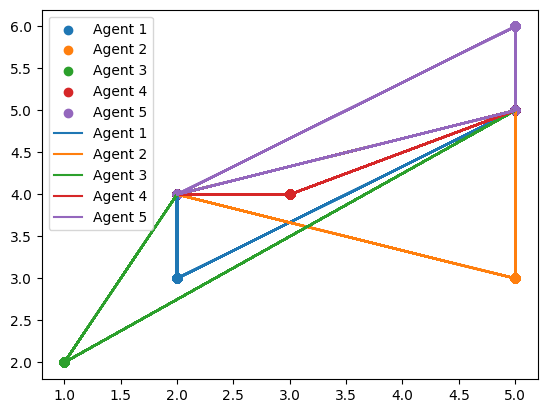

In [ ]:

positions = model.datacollector.get_model_vars_dataframe()

def extract_position(row, agent_index):
    return row['Agent Positions'][agent_index]

for i in range(N):
    positions[f'Agent {i+1}'] = positions.apply(lambda row: extract_position(row, i), axis=1)

fig, ax = plt.subplots()
for i in range(N):
    agent_col = f'Agent {i+1}'
    ax.scatter(positions[agent_col].apply(lambda x: x[0]), positions[agent_col].apply(lambda x: x[1]), label=agent_col)
    positions[f'Agent {i+1} X'] = [pos[i][0] for pos in positions['Agent Positions']]
    positions[f'Agent {i+1} Y'] = [pos[i][1] for pos in positions['Agent Positions']]

# each agent's trajectory
for i in range(N):
    ax.plot(positions[f'Agent {i+1} X'], positions[f'Agent {i+1} Y'], label=f'Agent {i+1}')

ax.legend()
plt.show()

Ara ja tenim agents que a cada moment del dia determinat van al lloc on els toca. Anem a incorporar la mensualitat de cada mes i plotar un histograma del total quan acabem tot el temps que hem posat. Ja veiem que quan superen un mes d'hores, es duplica el seu wealth. 

PREGUNTES: L'STEP de l'agent es util d'alguna manera, ho he posat tot al step del model perq necessito la variable time per definirho tot. 

La idea és que el model funcioni per qualsevol ciutat, li puguis tu adjuntar les dades de OPENDATA i runnejar quines polítiques redueixen la pobresa de la ciutat. 


In [ ]:
wealth = model.datacollector.get_agent_vars_dataframe()
wealth.groupby()
wealth_onestep = wealth.xs(0)['Wealth']
#agent_wealth = wealth_onestep.xs(0)['Wealth']

all_wealth = []

for agent in model.schedule.agents:
    wealth_onestep = wealth.xs(N)['Wealth'] #extract with xs the wealth values in agent_wealth
    agent_wealth = wealth_onestep(agent.unique_id)['Wealth']
    all_wealth.append(agent_wealth)  

plt.hist(all_wealth, bins=range(int(max(all_wealth)) + 1))
plt.show()  

AgentID
0    1066.500000
1     810.583333
2     827.666667
3    1026.500000
4     881.250000
Name: Wealth, dtype: float64

Ara ho anem a fer tot per districtes: Sarrià-sant gervasi, Eixample, Les Corts i Gràcia. 
Extreiem les dades d'aquests districtes en particular per diferents anys (tenim del 2015 fins 2020) i les subdividim mensualment.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Barcelona_districtes.svg/800px-Barcelona_districtes.svg.png width="200">

In [ ]:
import pandas as pd
import numpy as np
districtes = ['Gràcia', 'Sarrià-Sant Gervasi', 'Les Corts', 'Eixample']
renda2020 = pd.read_csv("C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/aporophobia_Alba/OpenData/2020_renda_neta_mitjana_per_persona.csv")
renda2020 = renda2020[renda2020['Nom_Districte'].isin(districtes)]
renda2020['Import_Euros'] = renda2020['Import_Euros'] / 12
district_wealth = {}
for district in districtes:
    district_wealth[district] = renda2020[renda2020['Nom_Districte'] == district]
    
district_wealth['Gràcia']

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Seccio_Censal,Import_Euros
499,2020,6,Gràcia,28,Vallcarca i els Penitents,1,1388.250000
500,2020,6,Gràcia,28,Vallcarca i els Penitents,2,1447.333333
501,2020,6,Gràcia,28,Vallcarca i els Penitents,3,1385.833333
502,2020,6,Gràcia,28,Vallcarca i els Penitents,4,1539.250000
503,2020,6,Gràcia,28,Vallcarca i els Penitents,6,1812.000000
...,...,...,...,...,...,...,...
581,2020,6,Gràcia,32,el Camp d'en Grassot i Gràcia Nova,84,1486.166667
582,2020,6,Gràcia,32,el Camp d'en Grassot i Gràcia Nova,85,1571.916667
583,2020,6,Gràcia,32,el Camp d'en Grassot i Gràcia Nova,86,1792.916667
584,2020,6,Gràcia,32,el Camp d'en Grassot i Gràcia Nova,87,1796.333333


També hem d'afegir l'edat dels agents : de moment ho farem posant un núm proporcional als agents del model. 
Per això de cada barri, guardarem un dataframe amb totes les edats i un porcentatge de quanta gent tñé aquella edat, dividida entre la total del districte. 
Preguntes: li afegeixo gender?   
Un cop tingui les edats assignades amb l'any 2020, utlitzao tambe les dades d'altres anys anteriors?????

In [5]:
#ASSIGN PROBABILIDAD A LAS EDADES
import pandas as pd
import numpy as np
edat2020 = pd.read_csv("C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/aporophobia_Alba/OpenData/2020_ine_edat_any_a_any_per_sexe.csv")
edat2020 = edat2020[edat2020['Nom_Districte'].isin(districtes)]
edat2020['Edat'] = edat2020['Edat_any_a_any'].str.extract('(\d+)').astype(int)
"""

#dataset separat en districtes. 
district_age = {}
for district in districtes:
    district_age[district] = edat2020[edat2020['Nom_Districte'] == district]
district_age['Gràcia'] """

# Calculate the total number of people in each district
total_people = edat2020.groupby(['Nom_Districte'])['Nombre'].sum()

# Calculate the number of people with each age in each district and then the percentage 
age_counts = edat2020.groupby(['Nom_Districte', 'Edat'])['Nombre'].sum()
age_percentages = age_counts / total_people

# Reset the index of the age_percentages dataframe
age_percentages = age_percentages.reset_index()

#creem un diccionari de probabilitas per a cada districte
probabilidades_por_distrito = age_percentages.groupby('Nom_Districte').apply(lambda x: dict(zip(x.Edat, x.Nombre))).to_dict()

def assign_age(distrito):
        probabilidades_edades = probabilidades_por_distrito[distrito]
        # Crear una lista de edades y una lista de sus probabilidades correspondientes
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        # Seleccionar aleatoriamente una edad del diccionario de acuerdo con las probabilidades del distrito
        edad_seleccionada = np.random.choice(edades, p=probabilidades)
        # Asignar la edad al agente
        return edad_seleccionada

assign_age('Gràcia')

#Assign district en proporció a la població real
def assign_district():
    district_probabilities = total_people / total_people.sum()
    district_selected = np.random.choice(total_people.index, p=district_probabilities)
    return district_selected


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/aporophobia_Alba/OpenData/2020_ine_edat_any_a_any_per_sexe.csv'

Let's place the model and agents in the districts. The new code city defines classes: 
- DistrictGrid: represents grid of districts with buildings of different types, each districtGrid object contains a name to identify the district, a dictionary 'locations' to map the buildings to their locations on the grid, and a list __busy_positions to keep track of the positions occupied. 

- CityModel: represents a city as a collection of districts. Each CItyModel object contains a 'name' attribute to identify the city and a dictionary 'districts' that maps district names to their DistrictGrid objects. The __init__ method sets the name and districts attributes. It takes a collection of DistrictGrid objects as input and converts it into a dictionary that maps each district's name to its object using a dictionary comprehension.

In [ ]:
#CODI NIEVES SENSE casi res: ara ja tenim agents assignats a cada grid. 
from mesa.space import MultiGrid
from mesa.model import Model
from typing import Collection, Dict, List, Tuple
import random
import mesa
N = 5
class Apo_Agent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.wealth = 0
        self.home = None
        self.age = None
        self.district = None

    def step(self):
        print("District of "+ str(self.unique_id) +" is " + str(self.district))
        

class DistrictGrid(MultiGrid):
    name: str
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, name: str, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        super().__init__(width, height, torus)
        self.name = name
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations

    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))

    def has_any_building(self, x: int, y: int) -> bool:
        return (x, y) in self.__busy_positions
    
    def has_building(self, type: str, x: int, y: int) -> bool:
        return (x, y) in self.locations[type]
    
    def add_location(self, type: str, x: int, y:int) -> None:
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N) -> None:
        self.num_agents = N
        self.name = name
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self)
            district_name = random.choice(list(self.districts.keys()))
            #print(district_name)
            #for district in self.districts.values():
            ag.district = district_name
            self.schedule.add(ag)

    def step(self):
        for district in self.districts.values():
            print(district.name)

        self.schedule.step()

if __name__ == '__main__':
    
    # crear dos districtes
    ciutat_vella = DistrictGrid(
        'Ciutat Vella',
        10,
        10,
        False,
        {'escola': [(0, 0), (7, 6)],
         'hospital': [(5, 5)]}
    )

    les_corts = DistrictGrid(
        'Les Corts',
        7,
        7,
        False,
        {'escola': [(5, 5)],
         'hospital': [(3, 1), (7, 3)]}
    )
    
    lista_distritos = [ciutat_vella, les_corts] 
    # crear la ciutat amb els dos districtes
    barcelona = CityModel('Barcelona', [ciutat_vella, les_corts], N)

    # on estan els hospitals de Les Corts
    print("Els hospitals de Les Corts:")
    print(barcelona.districts['Les Corts'].locations['hospital'])

    print("Escoles a Ciutat Vella:")
    print(barcelona.districts['Ciutat Vella'].locations['escola'])

    # posar una nova escola a ciutat vella
    barcelona.districts['Ciutat Vella'].add_location('escola', 4, 3)
    print("Noves escoles a Ciuta Vella:")
    print(barcelona.districts['Ciutat Vella'].locations['escola'])

    pass

for i in range(4):
    barcelona.step()

Els hospitals de Les Corts:
[(3, 1), (7, 3)]
Escoles a Ciutat Vella:
[(0, 0), (7, 6)]
Noves escoles a Ciuta Vella:
[(0, 0), (7, 6), (4, 3)]
Ciutat Vella
Les Corts
District of 1 is Ciutat Vella
District of 2 is Ciutat Vella
District of 3 is Ciutat Vella
District of 4 is Les Corts
District of 0 is Les Corts
Ciutat Vella
Les Corts
District of 3 is Ciutat Vella
District of 0 is Les Corts
District of 1 is Ciutat Vella
District of 2 is Ciutat Vella
District of 4 is Les Corts
Ciutat Vella
Les Corts
District of 1 is Ciutat Vella
District of 2 is Ciutat Vella
District of 0 is Les Corts
District of 3 is Ciutat Vella
District of 4 is Les Corts
Ciutat Vella
Les Corts
District of 3 is Ciutat Vella
District of 4 is Les Corts
District of 2 is Ciutat Vella
District of 0 is Les Corts
District of 1 is Ciutat Vella


In [ ]:
#CODI NIEVES: ara ja tenim agents assignats a cada grid q tenen el seu home assignat, i van al work dins del grid. Ja ho tinc visualitzat tmb. 
from mesa.space import MultiGrid
from mesa.model import Model
from typing import Collection, Dict, List, Tuple
import random
N = 2
class Apo_Agent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.wealth = 0
        self.home = None
        self.age = None
        self.district = None

    def step(self):
        #print("District of "+ str(self.unique_id) +" is " + str(self.district))
        print("Home of "+ str(self.unique_id) +" is " + str(self.home))
"""
    def go_to_work(self):
        self.model.districts.move_agent(self, self.random.choice(self.model.districts[str(self.district)].locations['work']))
    def go_home(self):
        self.model.districts.move_agent(self, self.home)
"""
class DistrictGrid(MultiGrid):
    name: str
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, name: str, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        super().__init__(width, height, torus)
        self.name = name
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations

    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))

    def has_any_building(self, x: int, y: int) -> bool:
        return (x, y) in self.__busy_positions
    
    def has_building(self, type: str, x: int, y: int) -> bool:
        return (x, y) in self.locations[type]
    
    def add_location(self, type: str, x: int, y:int) -> None:
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))

    def move_agent(self, agent, new_location):
        self.locations[agent.location].remove(agent)
        agent.location = new_location
        self.locations[new_location].append(agent)

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N) -> None:
        self.num_agents = N
        self.name = name
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = MultiGrid(width= 10, height= 10, torus= False) #ESTO PINTA FATALISIMO

        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self)
            district_name = random.choice(list(self.districts.keys()))
            #print(district_name)
            #for district in self.districts.values():
            ag.district = district_name
            ag.home = self.districts[str(district_name)].locations['houses'][i]
            self.schedule.add(ag)
            self.grid.place_agent(ag, ag.home)
        
    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                self.grid.place_agent(agent, agent.home)
        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                self.grid.move_agent(agent,  self.random.choice(self.districts[str(agent.district)].locations['work']))
        if 8 <= time < 17: 
            for agent in self.schedule.agents:
                self.grid.move_agent(agent,  self.random.choice(self.districts[str(agent.district)].locations['leisure']))
        if 17 <= time <= 23:
            for agent in self.schedule.agents:
                self.grid.move_agent(agent, agent.home)
        self.schedule.step()
        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print("Position of "+ str(agent.unique_id) + " at time " + str(time) + " is " + str(agent.pos) + " in district " + str(agent.district))
            
if __name__ == '__main__':
    
    # crear dos districtes
    ciutat_vella = DistrictGrid(
        'Ciutat Vella',
        10,
        10,
        False,
        {'escola': [(0, 0), (7, 6)],
         'work': [(5, 5)],
         'houses': [(1, 0), (4, 3)],
         'leisure': [(0, 1), (2, 4)]
         }
    )

    les_corts = DistrictGrid(
        'Les Corts',
        7,
        7,
        False,
        {'escola': [(5, 5)],
         'work': [(3, 1), (7, 3)],
         'houses': [(1, 2), (4, 6)],
         'leisure': [(0, 1), (2, 4)]}
    )

    lista_distritos = [ciutat_vella, les_corts] 
    # crear la ciutat amb els dos districtes
    barcelona = CityModel('Barcelona', [ciutat_vella, les_corts], N)

    pass

for i in range(20):
    barcelona.step()

Home of 1 is (4, 6)
Home of 0 is (1, 2)
Position of 0 at time 0 is (1, 2) in district Les Corts
Position of 1 at time 0 is (4, 6) in district Les Corts
Home of 1 is (4, 6)
Home of 0 is (1, 2)
Position of 0 at time 1 is (3, 1) in district Les Corts
Position of 1 at time 1 is (3, 1) in district Les Corts
Home of 0 is (1, 2)
Home of 1 is (4, 6)
Position of 0 at time 2 is (3, 1) in district Les Corts
Position of 1 at time 2 is (7, 3) in district Les Corts
Home of 0 is (1, 2)
Home of 1 is (4, 6)
Position of 0 at time 3 is (7, 3) in district Les Corts
Position of 1 at time 3 is (3, 1) in district Les Corts
Home of 0 is (1, 2)
Home of 1 is (4, 6)
Position of 0 at time 4 is (7, 3) in district Les Corts
Position of 1 at time 4 is (3, 1) in district Les Corts
Home of 0 is (1, 2)
Home of 1 is (4, 6)
Position of 0 at time 5 is (3, 1) in district Les Corts
Position of 1 at time 5 is (7, 3) in district Les Corts
Home of 0 is (1, 2)
Home of 1 is (4, 6)
Position of 0 at time 6 is (7, 3) in district Le

In [ ]:
#VISUALITZACIÓ EN DOS GRIDS: DOS DISTRICTES 
import pandas as pd
import mesa
import numpy as np
import matplotlib.pyplot as plt
from city import Apo_Agent, CityModel, DistrictGrid
from typing import Dict, List, Tuple
from matplotlib.colors import ListedColormap

income = pd.read_csv('C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/2020_atles_renda_bruta_persona.csv')
monthly_wealth = np.array(income['Import_Renda_Bruta_€']) / 12

# Define the color map using a list of colors
color_list = ["lightgrey", "orange", "red"]
wealth_cmap = ListedColormap(color_list)

ciutat_vella = DistrictGrid(
        'Ciutat Vella',
        10,
        10,
        False,
        {'escola': [(0, 0), (7, 6)],
         'work': [(5, 5)],
         'houses': [(1, 0), (4, 3)]}
    )

les_corts = DistrictGrid(
        'Les Corts',
        7,
        7,
        False,
        {'escola': [(5, 5)],
         'work': [(3, 1), (7, 3)],
         'houses': [(1, 2), (4, 6)]}
    )

districtes = [ciutat_vella, les_corts]

def agent_portrayal(agent):
    
    if agent.district == 'Les Corts':
        portrayal = {"Shape": "circle",
                     "Filled": "true",
                     "w": 1,
                     "h": 1,
                     "Layer": 0,
                     "Color": "green"}
        
    elif agent.district == 'Ciutat Vella':
        portrayal = {"Shape": "circle",
                     "Filled": "true",
                     "r": 0.5,
                     "Layer": 0,
                     "Color": "blue"}
    else:
        portrayal["r"] = 0.2
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1    
    
    return portrayal

#AQUI EL GRID DIVIDIT PER DISTRICTS.

districtgrid1 = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)
districtgrid2 = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)

server = mesa.visualization.ModularServer(
    CityModel, [districtgrid1, districtgrid2], "Aporophobia Model", {"name": "Barcelona", "districts": districtes, "N": 2}
)
server.port = 8521  # The default
server.launch()

A partir d'aquí afegim més agents i districtes al codi, a veure si funciona tot plegat. 
districtes = ['Gràcia', 'Sarrià-Sant Gervasi', 'Les Corts', 'Eixample'] 
Si augmentem el nombre d'agents, haurem d'afegir localitzacions a 'houses'.  FALTA PODER VISUALITZAR AIXÒ, aconseguir poosar grids al costat d'una i l'altre amb diferents width i tot això.
Agents tenen assignats edats random i van a l'escola o al work en funció d'això.

In [ ]:
#CODI NIEVES: ja tenim 4 districtes, i numero dagents variables (pero s'han d'adegir houses a la llista aleshores), 
#tenen random age i wealth assignat. Ara ho hauria de fer bé en funcio dels districtes. 

income = pd.read_csv('C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/2020_atles_renda_bruta_persona.csv')
monthly_wealth = np.array(income['Import_Renda_Bruta_€']) / 12


from mesa.space import MultiGrid
from mesa.model import Model
from typing import Collection, Dict, List, Tuple
import random
N = 5
class Apo_Agent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.wealth = 0
        self.home = None
        self.age = None
        self.district = None
        self.wealth = None

    def step(self):
        #print("District of "+ str(self.unique_id) +" is " + str(self.district))
        print("Home of "+ str(self.unique_id) +" is " + str(self.home))
"""
    def go_to_work(self):
        self.model.districts.move_agent(self, self.random.choice(self.model.districts[str(self.district)].locations['work']))
    def go_home(self):
        self.model.districts.move_agent(self, self.home)
"""
class DistrictGrid(MultiGrid):
    name: str
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, name: str, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        super().__init__(width, height, torus)
        self.name = name
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations

    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))

    def has_any_building(self, x: int, y: int) -> bool:
        return (x, y) in self.__busy_positions
    
    def has_building(self, type: str, x: int, y: int) -> bool:
        return (x, y) in self.locations[type]
    
    def add_location(self, type: str, x: int, y:int) -> None:
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))

    def move_agent(self, agent, new_location):
        self.locations[agent.location].remove(agent)
        agent.location = new_location
        self.locations[new_location].append(agent)

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N, wealthlist) -> None:
        self.num_agents = N
        self.name = name
        self.wealthlist = wealthlist
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = MultiGrid(width= 10, height= 10, torus= False) #ESTO PINTA FATALISIMO

        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self)
            district_name = random.choice(list(self.districts.keys()))
            #print(district_name)
            #for district in self.districts.values():
            ag.district = district_name
            ag.home = self.districts[str(district_name)].locations['houses'][i]
            ag.wealth = 0
            ag.age =  random.randint(0, 99)
            self.schedule.add(ag)
            self.grid.place_agent(ag, ag.home)
        
    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                self.grid.place_agent(agent, agent.home)
        # Schedule agents to go to work and leisure in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                if agent.age <= 22: 
                    self.grid.move_agent(agent,  self.random.choice(self.districts[str(agent.district)].locations['school']))
                if agent.age >= 22: 
                    self.grid.move_agent(agent,  self.random.choice(self.districts[str(agent.district)].locations['work']))

        if 8 <= time < 17: 
            for agent in self.schedule.agents:
                self.grid.move_agent(agent,  self.random.choice(self.districts[str(agent.district)].locations['leisure']))

        if 17 <= time <= 23:
            for agent in self.schedule.agents:
                self.grid.move_agent(agent, agent.home)
        
        #when a month has passed, mensuality is given to the agents

        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += self.wealthlist[agent.unique_id]

        self.schedule.step()
        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print("Position of "+ str(agent.unique_id) +" at time " + str(time) + " is " + str(agent.pos) + " in district " + str(agent.district))
            
if __name__ == '__main__':
    
    gracia = DistrictGrid(
        'Gràcia',
        10,
        10,
        False,
        {'school': [(0, 0), (7, 6)],
         'work': [(3, 1), (7, 3)],
         'houses': [(5, 5), (0, 1), (4, 4), (3, 0), (2, 1)],
         'leisure': [(0, 2), (2, 4)]}
    )

    les_corts = DistrictGrid(
        'Les Corts',
        7,
        7,
        False,
        {'school': [(5, 5)],
         'work': [(0, 0), (5, 1)],
         'houses': [(3, 1), (7, 3), (4, 4), (3, 0), (2, 1)],
         'leisure': [(0, 1), (2, 4)]}
    )

    sarria_stgervasi = DistrictGrid(
        'Sarrià-Sant Gervasi',
        10,
        10,
        False,
        {'school': [(5, 4)],
         'work' : [( 0, 1)],
         'houses': [(3, 0), (7, 8), (4, 4), (3, 1), (2, 1)],
         'leisure': [(0, 2), (2, 4)]}
    )

    eixample = DistrictGrid(
        'Eixample',
        7,
        7,
        False,
        {'school': [(5, 2)],
         'work' : [(2, 2)],
         'houses': [(3, 4), (3, 7), (4, 4), (3, 1), (2, 1)],
         'leisure': [(0, 1), (2, 4)]}
    )

    lista_distritos = [gracia, les_corts, eixample, sarria_stgervasi] 
    # crear la ciutat amb els quatre districtes
    barcelona = CityModel('Barcelona', lista_distritos, N, monthly_wealth)

    pass

for i in range(20):
    barcelona.step()

Home of 4 is (2, 1)
Home of 1 is (0, 1)
Home of 0 is (5, 5)
Home of 3 is (3, 1)
Home of 2 is (4, 4)
Position of 0 at time 0 is (5, 5) in district Gràcia
Position of 1 at time 0 is (0, 1) in district Gràcia
Position of 2 at time 0 is (4, 4) in district Sarrià-Sant Gervasi
Position of 3 at time 0 is (3, 1) in district Sarrià-Sant Gervasi
Position of 4 at time 0 is (2, 1) in district Sarrià-Sant Gervasi
Home of 0 is (5, 5)
Home of 4 is (2, 1)
Home of 1 is (0, 1)
Home of 3 is (3, 1)
Home of 2 is (4, 4)
Position of 0 at time 1 is (3, 1) in district Gràcia
Position of 1 at time 1 is (7, 3) in district Gràcia
Position of 2 at time 1 is (5, 4) in district Sarrià-Sant Gervasi
Position of 3 at time 1 is (0, 1) in district Sarrià-Sant Gervasi
Position of 4 at time 1 is (0, 1) in district Sarrià-Sant Gervasi
Home of 3 is (3, 1)
Home of 0 is (5, 5)
Home of 4 is (2, 1)
Home of 2 is (4, 4)
Home of 1 is (0, 1)
Position of 0 at time 2 is (7, 3) in district Gràcia
Position of 1 at time 2 is (3, 1) in di

In [ ]:
positions = barcelona.datacollector.get_model_vars_dataframe()
wealth= barcelona.datacollector.get_agent_vars_dataframe()
positions
wealth = wealth.reset_index()
wealth




,Step,AgentID,Wealth,District
0,0,0,1066.500000,Gràcia
1,0,1,810.583333,Eixample
2,0,2,827.666667,Eixample
3,0,3,1026.500000,Gràcia
4,0,4,881.250000,Les Corts
...,...,...,...,...
3495,699,0,2133.000000,Gràcia
3496,699,1,1621.166667,Eixample
3497,699,2,1655.333333,Eixample
3498,699,3,2053.000000,Gràcia


In [ ]:
import matplotlib.pyplot as plt
positions = barcelona.datacollector.get_model_vars_dataframe()
positions


def extract_position(row, agent_index):
    return row['Agent Positions'][agent_index]

for i in range(N):
    positions[f'Agent {i+1}'] = positions.apply(lambda row: extract_position(row, i), axis=1)

positions

,Agent Positions,Agent 1,Agent 2,Agent 3,Agent 4,Agent 5
0,"[(5, 5), (3, 7), (4, 4), (3, 0), (2, 1)]","(5, 5)","(3, 7)","(4, 4)","(3, 0)","(2, 1)"
1,"[(3, 1), (2, 2), (2, 2), (3, 1), (5, 1)]","(3, 1)","(2, 2)","(2, 2)","(3, 1)","(5, 1)"
2,"[(7, 3), (2, 2), (2, 2), (7, 3), (5, 1)]","(7, 3)","(2, 2)","(2, 2)","(7, 3)","(5, 1)"
3,"[(7, 3), (2, 2), (2, 2), (3, 1), (0, 0)]","(7, 3)","(2, 2)","(2, 2)","(3, 1)","(0, 0)"
4,"[(3, 1), (2, 2), (2, 2), (7, 3), (0, 0)]","(3, 1)","(2, 2)","(2, 2)","(7, 3)","(0, 0)"
...,...,...,...,...,...,...
695,"[(5, 5), (3, 7), (4, 4), (3, 0), (2, 1)]","(5, 5)","(3, 7)","(4, 4)","(3, 0)","(2, 1)"
696,"[(5, 5), (3, 7), (4, 4), (3, 0), (2, 1)]","(5, 5)","(3, 7)","(4, 4)","(3, 0)","(2, 1)"
697,"[(3, 1), (2, 2), (2, 2), (7, 3), (0, 0)]","(3, 1)","(2, 2)","(2, 2)","(7, 3)","(0, 0)"
698,"[(3, 1), (2, 2), (2, 2), (3, 1), (0, 0)]","(3, 1)","(2, 2)","(2, 2)","(3, 1)","(0, 0)"


In [ ]:

fig, ax = plt.subplots()
for i in range(N):
    agent_col = f'Agent {i+1}'
    ax.scatter(positions[agent_col].apply(lambda x: x[0]), positions[agent_col].apply(lambda x: x[1]), label=agent_col)
    positions[f'Agent {i+1} X'] = [pos[i][0] for pos in positions['Agent Positions']]
    positions[f'Agent {i+1} Y'] = [pos[i][1] for pos in positions['Agent Positions']]

# each agent's trajectory
for i in range(N):
    ax.plot(positions[f'Agent {i+1} X'], positions[f'Agent {i+1} Y'])

ax.legend()
plt.show()

NameError: name 'plt' is not defined

AQUÍ sota tenim cases que es generen automaticament a cada distericte per N numero d'agents. 

In [ ]:
#CODI NIEVES: ja tenim els agents i les cases q es generen automaticament a cada districte. 
import mesa
from mesa.space import MultiGrid
from mesa.model import Model
from typing import Collection, Dict, List, Tuple
import random
import pandas as pd
import numpy as np
N = 5

income = pd.read_csv('C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/2020_atles_renda_bruta_persona.csv')
monthly_wealth = np.array(income['Import_Renda_Bruta_€']) / 12

class Apo_Agent(mesa.Agent):
    def __init__(self, unique_id, model, age, district):
        super().__init__(unique_id, model)
        #self.wealth = 0
        self.home = None
        self.age = age
        self.district = district
        self.wealth = None

    def go_work(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['work']))

    def go_home(self):
        self.model.districts[self.district].place_agent(self, self.home)

    def go_school(self):
        #self.model.districts[self.district].move_agent(self, self.random.choice(self.model.districts[self.district].locations['school']))
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['school']))
    
    def step(self):
        print("Position of "+ str(self.unique_id) +" is " + str(self.pos))


class DistrictGrid(MultiGrid):
    name: str
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, name: str, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        super().__init__(width, height, torus)
        self.name = name
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations
        #print(self.__busy_positions)
    
    def get_busy_positions(self):
        return self.__busy_positions

    def generate_tuples(N, A, x_range, y_range):
        tuples = list()
        
        while len(tuples) < N:
                #random tuple
            x = random.randint(x_range[0], x_range[1])
            y = random.randint(y_range[0], y_range[1])
            t = (x, y)

            if t in A:
                continue
            if t in tuples:
                continue
            tuples.append(t)

        return tuples
        
    gracia_busy = gracia.get_busy_positions()
    eixample_busy = eixample.get_busy_positions()
    sarria_stgervasi_busy = sarria_stgervasi.get_busy_positions()
    les_corts_busy = les_corts.get_busy_positions()
    
    #houses_gracia = generate_tuples(5, gracia_busy, (0,10) , (0,10))
    #print(houses_gracia + gracia_busy + eixample_busy + sarria_stgervasi_busy + les_corts_busy)

    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))

    def has_any_building(self, x: int, y: int) -> bool:
        return (x, y) in self.__busy_positions
    
    def has_building(self, type: str, x: int, y: int) -> bool:
        return (x, y) in self.locations[type]
    
    def add_location(self, type: str, x: int, y:int) -> None:
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))

    def move_agent(self, agent, new_location):
        self.locations[agent.location].remove(agent)
        agent.location = new_location
        self.locations[new_location].append(agent)

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N, wealth_list) -> None:
        self.num_agents = N
        self.name = name
        self.wealth_list = wealth_list
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)
        #self.grid = MultiGrid(width= 10, height= 10, torus= False) #ESTO PINTA FATALISIMO, SI ERA
        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self, age = random.randint(10,99), district = random.choice(list(self.districts.keys())))
            ag.home = self.districts[ag.district].locations['houses'][i]
            ag.wealth = 0
            #busy.append(self.districts[ag.district].get_busy_positions())
            #print("Home of the agent: " + str(ag.unique_id)+ str(ag.home))
            self.schedule.add(ag)

        self.datacollector = mesa.DataCollector(
        model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]}, agent_reporters= {"Wealth": lambda a: a.wealth, "District": lambda a: a.district})

    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                print(agent.home)
                self.districts[agent.district].place_agent(agent, agent.home)
                #print(agent.pos)
        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                if agent.age < 18: 
                    agent.go_school()
                else:
                    agent.go_work()
        if 17 <= time <= 23:
            for agent in self.schedule.agents:
                agent.go_home()
            
        #when a month has passed, mensuality is given to the agents
        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += self.wealth_list[agent.unique_id]

        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print("Position of "+ str(agent.unique_id) +" at time " + str(time) + " is " + str(agent.pos) + " in district " + str(agent.district) + " with age " + str(agent.age))
            #busy.append(self.districts[agent.district].get_busy_positions)

        self.datacollector.collect(self)
        self.schedule.step()
    

if __name__ == '__main__':
    
    def generate_tuples(N, A, x_range, y_range):
        tuples = list()
       
        while len(tuples) < N:
            #random tuple
            x = random.randint(x_range[0], x_range[1])
            y = random.randint(y_range[0], y_range[1])
            t = (x, y)

            if t in A:
                continue
            if t in tuples:
                continue
            tuples.append(t)

        return tuples
    
    gracia = DistrictGrid(
        'Gràcia',
        10,
        10,
        False,
        {'school': [(0, 0), (7, 6)],
         'work': [(3, 1), (7, 3)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.gracia_busy, (0,9) , (0,9)) } #[(3, 2), (7, 4), (4, 4), (3, 0), (2, 1)]}  #generate_tuples(10, gracia_busy, (0,10) , (0,10))}
    )

    les_corts = DistrictGrid(
        'Les Corts',
        10,
        10,
        False,
        {'school': [(5, 5)],
         'work': [(0, 0), (5, 1)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.les_corts_busy, (0,9) , (0,9)) }#[(3, 1), (7, 3), (4, 4), (3, 0), (2, 1)]}
    )

    sarria_stgervasi = DistrictGrid(
        'Sarrià-Sant Gervasi',
        10,
        10,
        False,
        {'school': [(5, 4)],
         'work' : [( 0, 1)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.sarria_stgervasi_busy, (0,9) , (0,9)) }# [(3, 0), (7, 8), (4, 4), (3, 1), (2, 1)]}
    )

    eixample = DistrictGrid(
        'Eixample',
        10,
        10,
        False,
        {'school': [(5, 2)],
         'work' : [(2, 2)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.eixample_busy, (0,9) , (0,9)) } # [(3, 4), (3, 7), (4, 4), (3, 1), (2, 1)]}
    )

    lista_distritos = [gracia, les_corts, eixample, sarria_stgervasi] 
    
    # crear la ciutat amb els quatre districtes
    barcelona = CityModel('Barcelona', lista_distritos, N, monthly_wealth)
    #print(barcelona.districts["Gràcia"].get_busy_positions())
    pass

for i in range(700):
    barcelona.step()

NameError: name 'gracia' is not defined

FALTA ARREGLAR A DALT: 
No sé perquè em surt list index out of range quan de manera random assignem unes cases que no toquen. Era perquè teniem districtes amb grid 7x7. :/
Un cop ho tingui, arreglar la visualització per grids (no puc ferla amb mesa.visualization, no tinc el model amb grid definit) Intento posarli grid només epr la visualització, a ver si va. (però tampoco)

i ja començar amb el paper. 

In [ ]:
#ASSIGN PROBABILIDAD A LAS EDADES i Assign district en proporció a la població real
import pandas as pd
import numpy as np

income = pd.read_csv('C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/2020_atles_renda_bruta_persona.csv')
monthly_wealth = np.array(income['Import_Renda_Bruta_€']) / 12

edat2020 = pd.read_csv("C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/aporophobia_Alba/OpenData/2020_ine_edat_any_a_any_per_sexe.csv")
edat2020 = edat2020[edat2020['Nom_Districte'].isin(districtes)]
edat2020['Edat'] = edat2020['Edat_any_a_any'].str.extract('(\d+)').astype(int)
total_people = edat2020.groupby(['Nom_Districte'])['Nombre'].sum()
age_counts = edat2020.groupby(['Nom_Districte', 'Edat'])['Nombre'].sum()
age_percentages = age_counts / total_people
age_percentages = age_percentages.reset_index()
probabilidades_por_distrito = age_percentages.groupby('Nom_Districte').apply(lambda x: dict(zip(x.Edat, x.Nombre))).to_dict()

def assign_age(distrito):
        probabilidades_edades = probabilidades_por_distrito[distrito]
        # Crear una lista de edades y una lista de sus probabilidades correspondientes
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        # Seleccionar aleatoriamente una edad del diccionario de acuerdo con las probabilidades del distrito
        edad_seleccionada = np.random.choice(edades, p=probabilidades)
        # Asignar la edad al agente
        return edad_seleccionada

def assign_district():
    district_probabilities = total_people / total_people.sum()
    district_selected = np.random.choice(total_people.index, p=district_probabilities)
    return district_selected

probabilidades_edades = probabilidades_por_distrito['Gràcia']


list

In [ ]:
#CODI NIEVES: ja tenim els agents i les cases q es generen automaticament a cada districte. 
import mesa
from mesa.space import MultiGrid
from mesa.model import Model
from typing import Collection, Dict, List, Tuple
import random
N = 10

class Apo_Agent(mesa.Agent):
    def __init__(self, unique_id, model, district):
        super().__init__(unique_id, model)
        #self.wealth = 0
        self.home = None
        self.age = None
        self.district = district
        self.wealth = None

    def assign_age(self):
        probabilidades_edades = probabilidades_por_distrito[self.district]
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        self.age = np.random.choice(edades, p=probabilidades)

    def go_work(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['work']))
    
    def go_leisure(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['leisure']))

    def go_home(self):
        self.model.districts[self.district].place_agent(self, self.home)

    def go_school(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['school']))
    
    def step(self):
        print("Position of "+ str(self.unique_id) +" is " + str(self.pos))
    
class DistrictGrid(MultiGrid):
    name: str
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, name: str, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        super().__init__(width, height, torus)
        self.name = name
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations
    
    def get_busy_positions(self):
        return self.__busy_positions

    def generate_tuples(N, A, x_range, y_range):
        tuples = list()
        while len(tuples) < N:
            x = random.randint(x_range[0], x_range[1])
            y = random.randint(y_range[0], y_range[1])
            t = (x, y)
            if t in A:
                continue
            if t in tuples:
                continue
            tuples.append(t)
        return tuples
        
    gracia_busy = gracia.get_busy_positions()
    eixample_busy = eixample.get_busy_positions()
    sarria_stgervasi_busy = sarria_stgervasi.get_busy_positions()
    les_corts_busy = les_corts.get_busy_positions()

    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))

    def has_any_building(self, x: int, y: int) -> bool:
        return (x, y) in self.__busy_positions
    
    def has_building(self, type: str, x: int, y: int) -> bool:
        return (x, y) in self.locations[type]
    
    def add_location(self, type: str, x: int, y:int) -> None:
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))

    def move_agent(self, agent, new_location):
        self.locations[agent.location].remove(agent)
        agent.location = new_location
        self.locations[new_location].append(agent)

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N, wealth_list) -> None:
        self.num_agents = N
        self.name = name
        self.wealth_list = wealth_list
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)
        #self.grid = MultiGrid(width= 10, height= 10, torus= False) #ESTO PINTA FATALISIMO, SI ERA

        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self, district =  assign_district()) 
            ag.home = self.districts[ag.district].locations['houses'][i]
            ag.wealth = 0
            ag.assign_age()
            #print("Home of the agent: " + str(ag.unique_id)+ str(ag.home))
            self.schedule.add(ag)

        self.datacollector = mesa.DataCollector(
        model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]}, agent_reporters= {"Wealth": lambda a: a.wealth, "District": lambda a: a.district})

    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                print(agent.home)
                self.districts[agent.district].place_agent(agent, agent.home)

        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                if agent.age < 18: 
                    agent.go_school()
                else:
                    agent.go_work()

        if 8 <= time < 17: 
            for agent in self.schedule.agents:
                agent.go_leisure()

        if 17 <= time <= 23:
            for agent in self.schedule.agents:
                agent.go_home()
            
        #when a month has passed, mensuality is given to the agents
        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += self.wealth_list[agent.unique_id]

        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print("Position of "+ str(agent.unique_id) +" at time " + str(time) + " is " + str(agent.pos) + " in district " + str(agent.district) + " with age " + str(agent.age))

        self.datacollector.collect(self)
        self.schedule.step()
    

if __name__ == '__main__':
    
    def generate_tuples(N, A, x_range, y_range):
        tuples = list()
        while len(tuples) < N:
            #random tuple
            x = random.randint(x_range[0], x_range[1])
            y = random.randint(y_range[0], y_range[1])
            t = (x, y)
            if t in A:
                continue
            if t in tuples:
                continue
            tuples.append(t)
        return tuples
    
    gracia = DistrictGrid(
        'Gràcia',
        10,
        10,
        False,
        {'school': [(0, 0), (7, 6)],
         'work': [(3, 1), (7, 3)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.gracia_busy, (0,9) , (0,9)) } #[(3, 2), (7, 4), (4, 4), (3, 0), (2, 1)]}  
    )

    les_corts = DistrictGrid(
        'Les Corts',
        10,
        10,
        False,
        {'school': [(5, 5)],
         'work': [(0, 0), (5, 1)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.les_corts_busy, (0,9) , (0,9))}#[(3, 1), (7, 3), (4, 4), (3, 0), (2, 1)]}
    )

    sarria_stgervasi = DistrictGrid(
        'Sarrià-Sant Gervasi',
        10,
        10,
        False,
        {'school': [(5, 4)],
         'work' : [( 0, 1)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.sarria_stgervasi_busy, (0,9) , (0,9))}# [(3, 0), (7, 8), (4, 4), (3, 1), (2, 1)]}
    )

    eixample = DistrictGrid(
        'Eixample',
        10,
        10,
        False,
        {'school': [(5, 2)],
         'work' : [(2, 2)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.eixample_busy, (0,9) , (0,9))} # [(3, 4), (3, 7), (4, 4), (3, 1), (2, 1)]}
    )

    lista_distritos = [gracia, les_corts, eixample, sarria_stgervasi] 
    barcelona = CityModel('Barcelona', lista_distritos, N, monthly_wealth)
    pass

for i in range(700):
    barcelona.step()

NameError: name 'gracia' is not defined

In [4]:
#assign income:
import pandas as pd
import numpy as np
districtes = ['Gràcia', 'Sarrià-Sant Gervasi', 'Les Corts', 'Eixample']
renda2020 = pd.read_csv("C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/aporophobia/Aporophobia/OpenData/2020_renda_neta_mitjana_per_persona.csv")
renda2020['Nom_Districte'] = renda2020['Nom_Districte'].replace("L'Eixample", "Eixample")
renda2020 = renda2020[renda2020['Nom_Districte'].isin(districtes)]
pd.unique(renda2020['Nom_Districte'])
renda2020['Import_Euros'] = renda2020['Import_Euros'] / 12
district_wealth = {}
for district in districtes:
    district_wealth[district] = renda2020[renda2020['Nom_Districte'] == district]

def assign_income(distrito):
        district_income_data = district_wealth[distrito]
        income_probs = list(district_income_data['Import_Euros'] / district_income_data['Import_Euros'].sum())
        income = np.random.choice(district_income_data['Import_Euros'], p=income_probs)
        return income


,Any,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Sexe,Demanda_ocupacio,Nombre
4,2021,1,2,Eixample,5,el Fort Pienc,Dones,Atur Registrat,896
5,2021,1,2,Eixample,6,la Sagrada Família,Dones,Atur Registrat,1417
6,2021,1,2,Eixample,7,la Dreta de l'Eixample,Dones,Atur Registrat,1003
7,2021,1,2,Eixample,8,l'Antiga Esquerra de l'Eixample,Dones,Atur Registrat,1032
8,2021,1,2,Eixample,9,la Nova Esquerra de l'Eixample,Dones,Atur Registrat,1530
...,...,...,...,...,...,...,...,...,...
3505,2021,12,6,Gràcia,28,Vallcarca i els Penitents,Homes,Demanda No Aturats,107
3506,2021,12,6,Gràcia,29,el Coll,Homes,Demanda No Aturats,45
3507,2021,12,6,Gràcia,30,la Salut,Homes,Demanda No Aturats,85
3508,2021,12,6,Gràcia,31,la Vila de Gràcia,Homes,Demanda No Aturats,299


In [30]:
#CODI NIEVES: ja tenim els agents i les cases q es generen automaticament a cada districte. 
import mesa
from mesa.space import MultiGrid
from mesa.model import Model
from typing import Collection, Dict, List, Tuple
import random
N = 10

class Apo_Agent(mesa.Agent):
    def __init__(self, unique_id, model, district):
        super().__init__(unique_id, model)
        self.home = None
        self.age = None
        self.district = district
        self.wealth = None 

    def assign_income(self):
        district_income_data = district_wealth[self.district]
        income = district_income_data['Import_Euros'].tolist()
        income_probs = income / district_income_data['Import_Euros'].sum()
        prob = income_probs.tolist()
        self.wealth = np.random.choice(income, p=prob)

    def assign_age(self):
        probabilidades_edades = probabilidades_por_distrito[self.district]
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        self.age = np.random.choice(edades, p=probabilidades)

    def go_work(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['work']))
    
    def go_leisure(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['leisure']))

    def go_home(self):
        self.model.districts[self.district].place_agent(self, self.home)

    def go_school(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['school']))
    
    def step(self):
        #print("Position of "+ str(self.unique_id) +" is " + str(self.pos))
        print(self.wealth)
        
class DistrictGrid(MultiGrid):
    name: str
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, name: str, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        super().__init__(width, height, torus)
        self.name = name
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations
    
    def get_busy_positions(self):
        return self.__busy_positions

    def generate_tuples(N, A, x_range, y_range):
        tuples = list()
        while len(tuples) < N:
            x = random.randint(x_range[0], x_range[1])
            y = random.randint(y_range[0], y_range[1])
            t = (x, y)
            if t in A:
                continue
            if t in tuples:
                continue
            tuples.append(t)
        return tuples
    
    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))

    def has_any_building(self, x: int, y: int) -> bool:
        return (x, y) in self.__busy_positions
    
    def has_building(self, type: str, x: int, y: int) -> bool:
        return (x, y) in self.locations[type]
    
    def add_location(self, type: str, x: int, y:int) -> None:
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))

    def move_agent(self, agent, new_location):
        self.locations[agent.location].remove(agent)
        agent.location = new_location
        self.locations[new_location].append(agent)

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N) -> None:
        self.num_agents = N
        self.name = name
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self, district = assign_district()) 
            ag.home = self.districts[ag.district].locations['houses'][i]
            ag.assign_age()
            ag.assign_income()
            self.schedule.add(ag)

        self.datacollector = mesa.DataCollector(
        model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]}, agent_reporters= {"Wealth": lambda a: a.wealth})

    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                print(agent.home)
                self.districts[agent.district].place_agent(agent, agent.home)

        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                if agent.age < 18: 
                    agent.go_school()
                else:
                    agent.go_work()

        if 8 <= time < 17: 
            for agent in self.schedule.agents:
                agent.go_leisure()

        if 17 <= time <= 23:
            for agent in self.schedule.agents:
                agent.go_home()
          
        #when a month has passed, mensuality is given to the agents
        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += agent.wealth
                
        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print("Position of "+ str(agent.unique_id) +" at time " + str(time) + " is " + str(agent.pos) + " in district " + str(agent.district) + " with age " + str(agent.age))

        self.datacollector.collect(self)
        self.schedule.step()
    

if __name__ == '__main__':
    def generate_tuples(N, A, x_range, y_range):
        tuples = list()
        while len(tuples) < N:
            #random tuple
            x = random.randint(x_range[0], x_range[1])
            y = random.randint(y_range[0], y_range[1])
            t = (x, y)
            if t in A:
                continue
            if t in tuples:
                continue
            tuples.append(t)
        return tuples
    
    gracia_busy = gracia.get_busy_positions()
    eixample_busy = eixample.get_busy_positions()
    sarria_stgervasi_busy = sarria_stgervasi.get_busy_positions()
    les_corts_busy = les_corts.get_busy_positions()
    
    gracia = DistrictGrid(
        'Gràcia',
        10,
        10,
        False,
        {'school': [(0, 0), (7, 6)],
         'work': [(3, 1), (7, 3)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.gracia_busy, (0,9) , (0,9)) } #[(3, 2), (7, 4), (4, 4), (3, 0), (2, 1)]}  
    )

    les_corts = DistrictGrid(
        'Les Corts',
        10,
        10,
        False,
        {'school': [(5, 5)],
         'work': [(0, 0), (5, 1)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.les_corts_busy, (0,9) , (0,9))}#[(3, 1), (7, 3), (4, 4), (3, 0), (2, 1)]}
    )

    sarria_stgervasi = DistrictGrid(
        'Sarrià-Sant Gervasi',
        10,
        10,
        False,
        {'school': [(5, 4)],
         'work' : [( 0, 1)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.sarria_stgervasi_busy, (0,9) , (0,9))}# [(3, 0), (7, 8), (4, 4), (3, 1), (2, 1)]}
    )

    eixample = DistrictGrid(
        'Eixample',
        10,
        10,
        False,
        {'school': [(5, 2)],
         'work' : [(2, 2)],
         'leisure': [(3, 2), (7, 4)],
         'houses': DistrictGrid.generate_tuples(N, DistrictGrid.eixample_busy, (0,9) , (0,9))} # [(3, 4), (3, 7), (4, 4), (3, 1), (2, 1)]}
    )

    lista_distritos = [gracia, les_corts, eixample, sarria_stgervasi] 
    barcelona = CityModel('Barcelona', lista_distritos, N)
    pass

for i in range(700):
    barcelona.step()

NameError: name 'gracia' is not defined

In [ ]:
import matplotlib.pyplot as plt
positions = barcelona.datacollector.get_model_vars_dataframe()

def extract_position(row, agent_index):
    return row['Agent Positions'][agent_index]

for i in range(N):
    positions[f'Agent {i+1}'] = positions.apply(lambda row: extract_position(row, i), axis=1)

positions

wealth = barcelona.datacollector.get_agent_vars_dataframe()

#wealth.groupby()
wealth_onestep = wealth.xs(0)['Wealth']
#agent_wealth = wealth_onestep.xs(0)['Wealth']

all_wealth = []

for agent in barcelona.schedule.agents:
    print(agent.district)
    wealth_onestep = wealth.xs(N)['Wealth'] #extract with xs the wealth values in agent_wealth
    agent_wealth = wealth_onestep(agent.unique_id)['Wealth']
    all_wealth.append(agent_wealth)  

plt.hist(all_wealth, bins=range(int(max(all_wealth)) + 1))
plt.show() 

Eixample
Eixample
Sarrià-Sant Gervasi
Eixample
Sarrià-Sant Gervasi
Sarrià-Sant Gervasi
Gràcia
Gràcia
Les Corts
Sarrià-Sant Gervasi


Vale, a dalt ja tinc el model amb cases, edats, wealth i número d'agents a cada districte en proporció a dades reals. El següent pas és afegir més complexitat al model:
- Hauríem de mapejar espaialment els districtes per tenir també les localitzacions i tot automatic i en proporció. 
- Hauríem de deixar que els agents es moguessin d'un districte a un altre. 

- Fer homeless action: agents que tinguin home: null.
- Afegir status: student, employed, unemployed, retired. 
- Afegir accions: 

- Afegir needs: 



PROBLEMAS: Per la visualització haig de posar-ho tot en py files separats però no runneja en py files. 

In [22]:
gender2021 = pd.read_csv("C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/aporophobia/Aporophobia/OpenData/2021_Atur_per_sexe.csv")
gender2021 = gender2021[gender2021['Nom_Districte'].isin(districtes)]
gendergrouped = gender2021.groupby(['Nom_Districte', 'Sexe']).sum()
gendergrouped
# agrupar les dades pel codi de districte i sexe
grouped = gender2021.groupby(['Nom_Districte', 'Sexe'])

# sumar el nombre de persones en atur per cada grup
total_by_group = grouped['Nombre'].sum()

# calcular el nombre total de persones en atur per cada districte
total_by_district = total_by_group.groupby('Nom_Districte').sum()

# calcular el percentatge de dones i homes en atur per cada districte
(total_by_group / total_by_district)
gender2021
pd.unique(gender2021['Demanda_ocupacio'])

C:\Users\albaa\AppData\Local\Temp\ipykernel_20248\623318820.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gendergrouped = gender2021.groupby(['Nom_Districte', 'Sexe']).sum()


array(['Atur Registrat', 'Demanda No Aturats'], dtype=object)

Ara afegim needs basant-nos en la Maslow's hierarchy: 
Els hauríem d'afegir a la classe agent com un aspecte més dels agents, ha de ser un diccionari de categories amb needs a dins, ja amb weights associats directament. 
Una funcio a model ha de fer que cadascú d'aquests needs tingui un NSL weight que decaigui a cada step t. De manera inversa, la urgencia. 
Per decidir la següent acció tindrem la expected SAT que donara el nivell de satisfaccio de l'agent que s'espera un cop empleni need n despres de fer a en temps t. 

- Physiological : food, shelter, sleep, health
- Safety: clothing, financial security, employment
- Belonging: family, friendship, intimacy
- Esteem: freedom, status. self-esteem

Educació

<img src=https://simplypsychology.org/wp-content/uploads/maslow-hierachy-of-needs-min-1536x1086.jpg width="600">

We need to take into account that the importance weight will decrease from the bottom to the top of the pyramid, and the decaying rate and initial value will be different for each individual need based on the age, status of the agent. 

In [122]:
#LIST OF NSL VALUES AT TIME T PERFECTO
#normal dictionary
needs = {
    'physiological': ['food', 'shelter', 'sleep', 'health'],
    'safety': ['clothing', 'financial security', 'employment'],
    'belonging': ['family', 'friendship', 'intimacy'],
    'esteem': ['freedom', 'status', 'self-esteem']
}
#nested dicitonary
needs = {
    'physiological': {
        'needs': ['food', 'shelter', 'sleep', 'health'],
        'weight': 0.9,
        'decaying': [ 0.8,  0.5,  0.7,  0.3 ],
        'initial':  0.9
    },
    'safety': {
        'needs': ['clothing', 'financial security', 'employment'],
        'weight': 0.6,
        'decaying': [ 10,  5,  7 ],
        'initial':  0.8
    },
    'belonging': {
        'needs': ['family', 'friendship', 'intimacy'],
        'weight': 0.4,
        'decaying': [ 0.3,  0.4,  0.2 ],
        'initial':  0.8
    },
    'esteem': {
        'needs': ['freedom', 'status', 'self-esteem'],
        'weight': 0.2,
        'decaying': [ 0.2,  0.1,  0.3],
        'initial':  0.7
    }
}

needs['physiological']['decaying'][1]
len(needs['physiological']['needs'])

#Create empty lists of nsl final values and decay constant values 
decay =[]
nsl = []
#fill the decay list and the nsl with the decays of each category in needs and the initial value of each category
for category in needs:
    decay += [x for x in needs[category]['decaying']]
    num_needs = len(needs[category]['needs'])
    nsl += [needs[category]['initial']] * num_needs

#calculate the nsl list value at time t (if we want to store it in time: (should be a matrix then))
t = 2
for j in range(0, t):  #aquest for no cal, perque posarem la funcio al step de l'agent i a cada step ja ens fara el calcul.
    for i in range(0,len(nsl)):
        nsl[i]=nsl[i]*decay[i]
nsl

"""
#primer intento a agents
def NSL(self)-> List[float]:  
    nsl = []
    decay = []
    for category in self.needs:
        decay += [x for x in self.needs[category]['decaying']]
        num_needs = len(self.needs[category]['needs'])
        nsl += [self.needs[category]['initial']] * num_needs
    for i in range(0,len(self.nsl)):
        self.nsl[i]=self.nsl[i]*self.decay[i]
    return self.nsl

def Urg(self):
    nsl = self.NSL()
    return [1 - x for x in nsl]

#2n intento: aquest funciona, i m'inicialitza tot un diccionari amb els needs i l'nsl emplenat, pero sens urg.
 self.nsl = {}  # initialize nsl dictionary
        
        # populate nsl dictionary with initial values
        for category, category_data in self.needs.items():
            self.nsl[category] = {}
            for need in category_data['needs']:
                self.nsl[category][need] = category_data['initial']
    
    def update_nsl(self):
        for category, category_data in self.needs.items():
            for i, need in enumerate(category_data['needs']):
                self.nsl[category][need] *= category_data['decaying'][i]
"""

[0.5760000000000001,
 0.225,
 0.44099999999999995,
 0.081,
 80.0,
 20.0,
 39.2,
 0.072,
 0.12800000000000003,
 0.03200000000000001,
 0.027999999999999997,
 0.006999999999999999,
 0.063]

In [123]:
needs.items()
for category, category_data in needs.items():
                weight = category_data['weight']
                for need, nsl, urgency in zip(category_data['needs'], self.nsl[category], self.urg[category]):
                    i = actions.index(action)
                    j = needs_list.index(need)
                    sat = self.sat[j][i]
                    score += sat * urgency * weight

dict_items([('physiological', {'needs': ['food', 'shelter', 'sleep', 'health'], 'weight': 0.9, 'decaying': [0.8, 0.5, 0.7, 0.3], 'initial': 0.9}), ('safety', {'needs': ['clothing', 'financial security', 'employment'], 'weight': 0.6, 'decaying': [10, 5, 7], 'initial': 0.8}), ('belonging', {'needs': ['family', 'friendship', 'intimacy'], 'weight': 0.4, 'decaying': [0.3, 0.4, 0.2], 'initial': 0.8}), ('esteem', {'needs': ['freedom', 'status', 'self-esteem'], 'weight': 0.2, 'decaying': [0.2, 0.1, 0.3], 'initial': 0.7})])

I see, in that case you can modify the NSL function to take the current step of the agent as an argument instead of a time t, and calculate the corresponding value of t based on the step number. Here's an updated implementation:

class Apo_Agent(mesa.Agent):
    needs: Dict[str, List[str]]
    decaying_constants: Dict[str, float]

    def NSL(self, step_num: int) -> Dict[str, List[float]]:
        nsl_values = {}
        for category, category_needs in self.needs.items():
            a = self.decaying_constants[category]
            t = step_num  # Calculate t based on the step number
            nsl_values[category] = [math.exp(a * t * -0.8) for _ in category_needs]
        return nsl_values
Here, the NSL function takes the current step number step_num as an argument, and calculates the corresponding value of t as simply step_num. The rest of the function remains the same as before, with the NSL values calculated using the formula 0.8 * e^(a * t) as before.

Again, note that this implementation assumes that the needs attribute is a dictionary that maps category names to lists of needs within each category. If your implementation of the needs dictionary is different, you may need to modify the code accordingly.

Needs: food and water, shelter, sleep, clothing, health, financial security, employment, family, friendship, intimacy, freedom, status, self-esteem. 

Actions: go home (implica dormir i menjar), go grocery, go work, go hospital, go shopping, go leisure. 

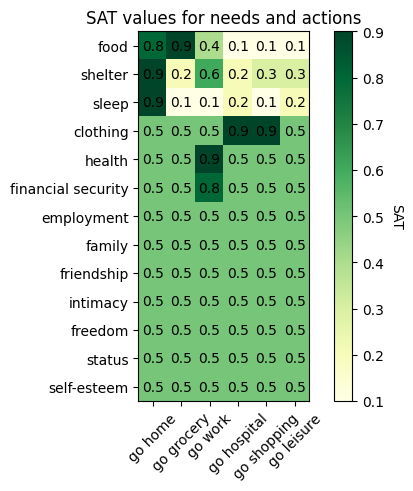

In [103]:

needs = ["food", "shelter", "sleep", "clothing", "health", "financial security", "employment", "family", "friendship", "intimacy", "freedom", "status", "self-esteem"]
actions = ["go home", "go grocery", "go work", "go hospital", "go shopping", "go leisure"]

#1ERA MANERA 
# Initialize the matrix with zeros
SAT_matrix = [[0.0 for _ in range(len(actions))] for _ in range(len(needs))]
for i, n in enumerate(needs):
    for j, a in enumerate(actions):
        if n == "food" and a == "go home":
            SAT_matrix[i][j] = 0.8
        elif n == "food" and a == "go grocery":
            SAT_matrix[i][j] = 0.9
        else:
            # Assign a default SAT value of 0.5 for all other pairs
            SAT_matrix[i][j] = 0.5
            
def get_SAT(n, a):
    i = needs.index(n)
    j = actions.index(a)
    return SAT_matrix[i][j]

#2NA MANERA
# Define the SAT values for each pair of need and action
SAT_values = [
    [0.8, 0.9, 0.4, 0.1, 0.1, 0.1],
    [0.9, 0.2, 0.6, 0.2, 0.3, 0.3],
    [0.9, 0.1, 0.1, 0.2, 0.1, 0.2],
    [0.5, 0.5, 0.5, 0.9, 0.9, 0.5],
    [0.5, 0.5, 0.9, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.8, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
]

# Create a matrix of SAT values
SAT_matrix = np.array(SAT_values)

def get_SAT(n, a):
    i = needs.index(n)
    j = actions.index(a)
    return SAT_matrix[i][j]

import matplotlib.pyplot as plt

# Create a heatmap of the SAT values
fig, ax = plt.subplots()
im = ax.imshow(SAT_matrix, cmap='YlGn')

# Set the axis labels
ax.set_xticks(range(len(actions)))
ax.set_yticks(range(len(needs)))
ax.set_xticklabels(actions, rotation=45)
ax.set_yticklabels(needs)

# Set the colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("SAT", rotation=-90, va="bottom")

# Loop over the data and create the annotations
for i in range(len(needs)):
    for j in range(len(actions)):
        text = ax.text(j, i, SAT_matrix[i][j], ha="center", va="center", color="black")

# Set the plot title and show the plot
ax.set_title("SAT values for needs and actions")
plt.show()


In [78]:
#llegir les dades de internet: fracaso total
import json
import pandas as pd
from urllib.request import urlopen
import csv

url = 'https://opendata-ajuntament.barcelona.cat/data/es/dataset/renda-tributaria-per-persona-atlas-distribucio/resource/f791aeba-2570-4e37-b957-c6036a0c28f7?inner_span=True'
data = urlopen(url).read() #.decode('utf-8')  #gives a byte str representation of a json object

#csv.reader(data) 
"""
data_dict = json.loads(data)
df = pd.DataFrame(data_dict['result']['records']) """
data


#2nd attempt
import requests
import pandas as pd
from io import StringIO

url = 'https://opendata-ajuntament.barcelona.cat/data/es/dataset/renda-tributaria-per-persona-atlas-distribucio/resource/f791aeba-2570-4e37-b957-c6036a0c28f7?inner_span=True'

# Get the HTML content of the website
response = requests.get(url)
html_content = response.text

# Find the CSV data within the HTML content using string manipulation
start = html_content.find('data-csv="') + len('data-csv="')
end = html_content.find('"', start)
csv_data = html_content[start:end].replace('&quot;', '"').replace('&lt;', '<').replace('&gt;', '>').replace('&nbsp;', ' ')

csv_data
# Read the CSV data into a Pandas dataframe
df = pd.read_csv(StringIO(csv_data))
df

' html>\n<!--[if IE 7]> <html lang='

In [79]:
#AQUI INTENTO PASSARHO A HTML, PERO NOMES SERA ACCESIBLE DESDE LA LOCAL MACHINE IGUAL 
import pandas as pd
import http.server
import socketserver

# Read the CSV data into a Pandas dataframe
df = pd.read_csv('https://opendata-ajuntament.barcelona.cat/data/es/dataset/renda-tributaria-per-persona-atlas-distribucio/resource/f791aeba-2570-4e37-b957-c6036a0c28f7')

# Generate an HTML file from the dataframe
html_file = 'renda2020.html'
with open(html_file, 'w') as f:
    f.write(df.to_html())

# Serve the HTML file on a web server
PORT = 8000
Handler = http.server.SimpleHTTPRequestHandler

with socketserver.TCPServer(("", PORT), Handler) as httpd:
    print("Serving at port", PORT)
    httpd.serve_forever()


C:\Users\albaa\AppData\Local\Temp\ipykernel_6084\333055559.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  renda2020 = pd.read_csv('https://opendata-ajuntament.barcelona.cat/data/es/dataset/renda-tributaria-per-persona-atlas-distribucio/resource/f791aeba-2570-4e37-b957-c6036a0c28f7', error_bad_lines=False)
Skipping line 17: expected 1 fields, saw 2
Skipping line 796: expected 1 fields, saw 8
Skipping line 958: expected 1 fields, saw 2
Skipping line 959: expected 1 fields, saw 2
Skipping line 1120: expected 1 fields, saw 7
Skipping line 1121: expected 1 fields, saw 3
Skipping line 1122: expected 1 fields, saw 2
Skipping line 1123: expected 1 fields, saw 5
Skipping line 1125: expected 1 fields, saw 3
Skipping line 1126: expected 1 fields, saw 2



ParserError: Error tokenizing data. C error: Expected 1 fields in line 17, saw 2


In [ ]:

#CONCLUSIO: millor ho penjo a github i que accedeixi al github directament.
import requests
import csv

# Set up the API request
url = "https://api.github.com/repos/{username}/{repository}/contents/{filepath}"
username = "your-github-username"
repository = "your-github-repository"
filepath = "path/to/your/csv/file.csv"
token = "your-github-access-token"

headers = {"Authorization": f"token {token}"}
params = {"ref": "main"} # replace "main" with the name of your branch if it's different

response = requests.get(url.format(username=username, repository=repository, filepath=filepath), headers=headers, params=params)

# Decode the response content
content = response.content.decode()

# Parse the CSV data
data = csv.reader(content.splitlines())

# Do something with the data
for row in data:
    print(row)


In [ ]:
#codi amb nsl i urg values que s'actualitzen i es recollecten

import mesa
import numpy as np
from data import probabilidades_por_distrito, district_wealth
from typing import Collection, Dict, List, Tuple
import math 

class Apo_Agent(mesa.Agent):
    needs: Dict[str, List[str]] #Diccionari principal definit, res del nested de dins.

    def __init__(self, unique_id, model, district, needs: Dict[str, List[str]]):
        super().__init__(unique_id, model)
        self.home = None
        self.age = None
        self.district = district
        self.wealth = None 
        self.status = None
        self.gender = None
        self.needs = needs
        self.nsl = {category: [self.needs[category]['initial']] * len(self.needs[category]['needs']) for category in self.needs}
        self.urg = {category: [1-self.needs[category]['initial']] * len(self.needs[category]['needs']) for category in self.needs}
    
    def update_nsl_and_urg(self):
        for category in self.needs:
            decay = self.needs[category]['decaying']
            for i in range(len(self.nsl[category])):
                self.nsl[category][i] *= decay[i]
                self.urg[category][i] = 1 - self.nsl[category][i]
        
    def assign_income(self):
        district_income_data = district_wealth[self.district]
        income = district_income_data['Import_Euros'].tolist()
        income_probs = income / district_income_data['Import_Euros'].sum()
        prob = income_probs.tolist()
        self.wealth = np.random.choice(income, p=prob)

    def assign_age_and_status(self):
        probabilidades_edades = probabilidades_por_distrito[self.district]
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        self.age = np.random.choice(edades, p=probabilidades)

        if self.age <= 16:
            self.status = "student"
        elif 16 < self.age <=22:
            self.status = np.random.choice(["student", "employed", "unemployed"])
        elif 22 < self.age <= 67:
            self.status = np.random.choice([ "employed", "unemployed"])
        else: self.status = ["retired"]

    def go_work(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['work']))
    
    def go_leisure(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['leisure']))

    def go_home(self):
        self.model.districts[self.district].place_agent(self, self.home)

    def go_school(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['school']))

    def step(self):
        #print(self.needs['physiological']['weight'])
        self.update_nsl_and_urg()
        

        print(self.nsl)
        print(self.urg)
        print(self.wealth)


import mesa 
from city import DistrictGrid
from typing import Collection, Dict, List, Tuple
from agent import Apo_Agent
from data import assign_district

N = 5

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N) -> None:
        self.num_agents = N
        self.name = name
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self, district = assign_district(), needs = needs) 
            ag.home = self.districts[ag.district].locations['houses'][i]
            ag.assign_age_and_status()
            ag.assign_income()
            self.schedule.add(ag)
            
        self.datacollector = mesa.DataCollector(
        model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]},
        agent_reporters={
                "nsl": lambda a: a.nsl,
                "urg": lambda a: a.urg,
            })

    def step(self):
        time = self.schedule.time % 24
            
        if time == 0: 
            for agent in self.schedule.agents:
                self.districts[agent.district].place_agent(agent, agent.home)

        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                if agent.age < 18: 
                    agent.go_school()
                else:
                    agent.go_work()

        if 8 <= time < 17: 
            for agent in self.schedule.agents:
                agent.go_leisure()

        if 17 <= time <= 23:
            for agent in self.schedule.agents:
                agent.go_home()
          
        #when a month has passed, mensuality is given to the agents
        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += agent.wealth
                
        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print("Position of "+ str(agent.unique_id) +" at time " + str(time) + " is " + str(agent.pos) + " in district " + str(agent.district) + " with age " + str(agent.age) + " and busy positions " + str())

        self.datacollector.collect(self)
        self.schedule.step()
    

if __name__ == '__main__':

    gracia = DistrictGrid(
        'Gràcia',
        10,
        10,
        False,
        {'school': [(0, 0), (7, 6)],
         'work': [(3, 1), (7, 3)],
         'leisure': [(3, 2), (7, 4)]}
    )
    #gracia.locations['houses'] = gracia.generate_tuples(N, (0,9) , (0,9))

    les_corts = DistrictGrid(
        'Les Corts',
        10,
        10,
        False,
        {'school': [(5, 5)],
         'work': [(0, 0), (5, 1)],
         'leisure': [(3, 2), (7, 4)]}
    )

    sarria_stgervasi = DistrictGrid(
        'Sarrià-Sant Gervasi',
        10,
        10,
        False,
        {'school': [(5, 4)],
         'work' : [( 0, 1)],
         'leisure': [(3, 2), (7, 4)]}
    )

    eixample = DistrictGrid(
        'Eixample',
        10,
        10,
        False,
        {'school': [(5, 2)],
         'work' : [(2, 2)],
         'leisure': [(3, 2), (7, 4)]}
    )

    lista_distritos = [gracia, les_corts, eixample, sarria_stgervasi] 

    needs = {
    'physiological': {
        'needs': ['food', 'shelter', 'sleep', 'health'],
        'weight': 0.9,
        'decaying': [ 0.8,  0.5,  0.7,  0.3 ],
        'initial':  0.9
    },
    'safety': {
        'needs': ['clothing', 'financial security', 'employment'],
        'weight': 0.6,
        'decaying': [ 0.5,  0.6,  0.5 ],
        'initial':  0.8
    },
    'belonging': {
        'needs': ['family', 'friendship', 'intimacy'],
        'weight': 0.4,
        'decaying': [ 0.3,  0.4,  0.2 ],
        'initial':  0.8
    },
    'esteem': {
        'needs': ['freedom', 'status', 'self-esteem'],
        'weight': 0.2,
        'decaying': [ 0.2,  0.1,  0.3],
        'initial':  0.7
    }
}

    #GENERATE HOUSES FOR N AGENTS
    for district in lista_distritos:
        district.locations['houses'] = district.generate_tuples(N, (0, 9), (0, 9))

    barcelona = CityModel('Barcelona', lista_distritos, N)
    pass

for i in range(4):
    barcelona.step()

Aquí a dalt ja tenim els nsl i urg values per cada agent que es van recollectant, de fet podriem fer una visualiztacio per veure els nsl i els urg en funcio del temps com decauen (per la memòria). Ara mateix tots els agents tenen els mateixos valors perq ens falta incorporar el factor que farà que l'accio influeixi en el valor. i cada agent fara una accio diferent segons el seu estatus, edat, etc. 
Hauria de fer que si l'edat es adolescencia, el decaying the friends sigui més fort.ç
Si l'edat es elevada, el decay de salud també, etc. 


A part hauriem de tenir un set de totes les accions per posar la funció SAT al model, que sera tal qual una matriu de needs i accions.
Al seu torn, la a[t] serà un llista d'scores calculat per tot el set d'accions que tinguem, pero es quedara amb l'argmax de la llista. 
Cada element de la llista es calculara multiplicant el value sat d'aquellla accio i tots els needs per l'urg de cada need, per l'importancia de la categoria del need. 
for category in needs[category]
    for need in needs: 
        SAT (a, need)* urg(need)* Imp()

In [3]:
needs_list = ["food", "shelter", "sleep", "clothing", "health", "financial security", "employment", "family", "friendship", "intimacy", "freedom", "status", "self-esteem"]
actions_list = ["go home", "go grocery", "go work", "go hospital", "go shopping", "go leisure"]
    
    #1ERA MANERA 
    # Initialize the matrix with zeros
SAT_matrix = [[0.0 for _ in range(len(actions_list))] for _ in range(len(needs_list))]
for i, n in enumerate(needs_list):
    for j, a in enumerate(actions_list):
        if n == "food" and a == "go home":
            SAT_matrix[i][j] = 0.8
        elif n == "food" and a == "go grocery":
            SAT_matrix[i][j] = 0.9
        else:
                # Assign a default SAT value of 0.5 for all other pairs
            SAT_matrix[i][j] = 0.5
                
def get_SAT(n, a):
    i = needs_list.index(n)
    j = actions_list.index(a)
    return SAT_matrix[i][j]

get_SAT()

def get_scores(self):
        scores = []
        for action in actions_list:
            score = 0
            for category, category_data in self.needs.items():
                weight = category_data['weight']
                for need, nsl, urgency in zip(category_data['needs'], self.nsl[category], self.urg[category]):
                    i =  actions_list.index(action)
                    j =  needs_list.index(need)
                    sat = self.sat[j][i]
                    score += sat * urgency * weight
            scores.append(score)
        return scores

In [ ]:
scores=[] #ha de tenir la length de les accions

for category in needs[category]:
    for needs in needs[category]['needs']:
        scores.append( urg[] * needs[category]['weight'])

#np.argmax(scores)


Tenim valors nsl i urg associats a cada need, que van decaient com més steps de temps fem en el model. 

Ja tinc la matriu sat afegida al model, tots els agents tenen la mateixa. 
Ara hauria de poder calcular els scores amb SAT * URG * WEIGHT. 


Ja estan els scores calculats i la accio escollida a cada step de temps en funcio daixo, ara:

- ho hauria d ocmplementar amb la resta daccions que ja estan definides per temps a l'step del model (hauria de deixarls fixes tot i els scores i tot aixo?) és a dir, que es facni independetment de l'accio amb més score, o potser hauria de sortir natural amb el needs model? (esto lo veo complicado). Haig de posar que sleep i food decaigui de manera ciclica potser? 

- hauria de mirar d'OMPLIR la SAT i les needs amb coses raonables que escullin una altra cosa que no sigui food jajajjaa

- hauria de trobar una manera bien de VISUALITZAR les nsl baixant a cada step, les urg pujant, els agents moventse en el grid etc. 

- hauria de fer que els NSL s'omplissin en funcio de SAT? CREO, quan escollim una accio que fa que pugi una miqueta, pero clar no pot superar el 0 al 1 no? potser hauria de omplirho en proporcio al valor nsl que ja hi ha o algo. 

- ara mateix les LOCATIONS són 0 determinants pel model!



PLUJA D'IDEES: valors SAT
- Els valors de SAT haurien de ser sumats en proporció al valor NSL que tenim? 